In [0]:

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

     |██████████▉                     | 200.4MB 567kB/s eta 0:11:31
ERROR: Operation cancelled by user


KeyboardInterrupt: ignored

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2 

In [29]:
from google.colab import drive
drive.mount('/content/gdrive');

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Import train, validation and test images from the folders and store in a list

import os

# To load images

def load_img(folder):
    c = 0;
    images = [];
    for filename in os.listdir(folder): # List all the filenames in the folder
        c = c + 1;
        print(c);
        img = cv2.imread(os.path.join(folder, filename)); # Join the link of the folder and filename
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA);
        images.append(img);
    return images

# To load labeled gray-scaled images

def load_label_img(folder):
    images = [];
    c = 0;
    for filename in os.listdir(folder): # List all the filenames in the folder
        c = c + 1;
        print(c);
        img = cv2.imread(os.path.join(folder, filename)); # Join the link of the folder and filename
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
        images.append(img);
    return images


In [0]:
# Convert the output labels to pixel-wise classes

def c2g(cn):
    cn = np.reshape(cn, (1, 1, 3));
    cn = cv2.cvtColor(cn, cv2.COLOR_BGR2GRAY);
    return cn;

colors = [];
colors.append(c2g(np.array([64, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 64], dtype = 'uint8')));

# c0 = np.reshape(np.array([64, 128, 0], dtype = 'uint8'), (1, 1, 3)); # opencv supports uint8 and not int32/int64
# c0 = cv2.cvtColor(c0, cv2.COLOR_BGR2GRAY)
# print(c0)

def class_pixel(label_img):
    class_pix = np.ones([128, 128, 1], dtype = int);
    for index, c in enumerate(colors):
        class_pix[label_img == c] = index; # Vectorized masking is much much faster
    return class_pix



In [0]:
# Convert all segmented images into labeled images

def label_img_list(img_list):
    images = [];
    for image in img_list:
        images.append(class_pixel(image));
    return images;


In [33]:
# Define the transformations that have to be applied on the images

transform_img = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],   # input[channel] = (input[channel] - mean[channel]) / std[channel]
                        std=[0.5, 0.5, 0.5])])

transform_img_label = transforms.Compose([
    transforms.ToTensor()
])

from torch.utils.data import Dataset, DataLoader

# We have to create custom classes in order to use the DataLoader. These classes inherit the Dataset class

class trainset(data.Dataset):
    def __init__(self, transform = None, root_train = None, root_train_label = None, transform_label = None):
        self.train_img = load_img(root_train);
        self.transform = transform;
        self.transform_label = transform_label;
        self.train_label_img = label_img_list(load_label_img(root_train_label));
        
    def __len__(self):
        return len(self.train_img);
    
    def __getitem__(self, index):
        img = self.transform(self.train_img[index]);
        label = self.transform_label(self.train_label_img[index]);
        return img, label;

class valset(data.Dataset):
    def __init__(self, transform = None, root_val = None, root_val_label = None, transform_label = None):
        self.val_img = load_img(root_val);
        self.transform = transform;
        self.transform_label = transform_label;
        self.val_label_img = label_img_list(load_label_img(root_val_label));
        
    def __len__(self):
        return len(self.val_img);
    
    def __getitem__(self, index):
        img = self.transform(self.val_img[index]);
        label = self.transform_label(self.val_label_img[index]);
        return img, label

    
class testset(data.Dataset):
    def __init__(self, transform = None, root_test = None, root_test_label = None, transform_label = None):
        self.test_img = load_img(root_test);
        self.transform = transform;
        self.transform_label = transform_label;
        self.test_label_img = label_img_list(load_label_img(root_test_label));
        
    def __len__(self):
        return len(self.test_img);
    
    def __getitem__(self, index):
        img = self.transform(self.test_img[index]);
        label = self.transform_label(self.test_label_img[index]);
        return img, label


traindataset = trainset(transform_img, '/content/gdrive/My Drive/Camvid dataset/train/', '/content/gdrive/My Drive/Camvid dataset/train_labels/', transform_img_label);
# valdataset = valset(transform_img, '/content/gdrive/My Drive/Camvid dataset/val/', '/content/gdrive/My Drive/Camvid dataset/val_labels/', transform_img_label);
testdataset = testset(transform_img, '/content/gdrive/My Drive/Camvid dataset/test/', '/content/gdrive/My Drive/Camvid dataset/test_labels/', transform_img_label);

# We have to instantiate these classes and feed this to the dataloader

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
train_loader = data.DataLoader(traindataset, batch_size = 1, shuffle=True,  num_workers=4);
# val_loader = data.DataLoader(valdataset, batch_size = 32, shuffle=True,  num_workers=4);
test_loader = data.DataLoader(testdataset, batch_size = 1, shuffle=True,  num_workers=4);

In [0]:
class u_net(nn.Module):

  def __init__(self):
    super().__init__();
    self.conv1 = nn.Conv2d(3, 64, 3);
    self.conv2 = nn.Conv2d(64, 128, 3);
    self.conv3 = nn.Conv2d(128, 256, 3);
    self.conv4 = nn.Conv2d(256, 512, 3);
    self.conv5 = nn.Conv2d(512, 1024, 3);
    self.conv6 = nn.Conv2d(1024, 512, 3);
    self.conv7 = nn.Conv2d(512, 512, 3);
    self.conv8 = nn.Conv2d(512, 256, 3);
    self.conv9 = nn.Conv2d(256, 256, 3);
    self.conv10 = nn.Conv2d(256, 128, 3);
    self.conv11 = nn.Conv2d(128, 128, 3);
    self.b1 = nn.BatchNorm2d(64);
    self.b2 = nn.BatchNorm2d(128);
    self.b3 = nn.BatchNorm2d(256);
    self.b4 = nn.BatchNorm2d(512);
    self.b5 = nn.BatchNorm2d(1024);
    self.convT1 = nn.ConvTranspose2d(1024, 512, 2, 2);
    self.convT2 = nn.ConvTranspose2d(512, 256, 2, 2);
    self.convT3 = nn.ConvTranspose2d(256, 256, 2, 2);
    self.convT4 = nn.ConvTranspose2d(128, 64, 2, 2);
    self.convT5 = nn.ConvTranspose2d(64, 32, 2, 2);
    self.pool1 = nn.MaxPool2d(2, 2);

  def forward(self, x):
    x = F.relu(self.b1(self.conv1(x)));
    x = F.relu(self.b2(self.conv2(x)));
    x = self.pool1(x);
    x = F.relu(self.b2(self.conv11(x)));
    x = F.relu(self.b3(self.conv3(x)));
    x1 = x;
    x1 = x1[:, :, int((58 - 24)/2) : int((58 + 24)/2), int((58 - 24)/2) : int((58 + 24)/2)];
    x = self.pool1(x);
    x = F.relu(self.b3(self.conv9(x)));
    x = F.relu(self.b4(self.conv4(x)));
    x2 = x;
    x2 = x2[:, :, int((25 - 16)/2) : int((25 + 16)/2), int((25 - 16)/2) : int((25 + 16)/2)];
    x = self.pool1(x);
    x = F.relu(self.b4(self.conv7(x)));
    x = F.relu(self.b5(self.conv5(x)));
    x = self.b4(self.convT1(x));
    x = torch.cat((x2, x), dim = 1);
    x = F.relu(self.b4(self.conv6(x)));
    x = F.relu(self.b4(self.conv7(x)));
    x = self.b3(self.convT2(x));
    x = torch.cat((x1, x), dim = 1);
    x = F.relu(self.b3(self.conv8(x)));
    x = F.relu(self.b3(self.conv9(x)));
    x = self.b3(self.convT3(x));
    x = F.relu(self.b2(self.conv10(x)));
    x = F.relu(self.b2(self.conv11(x)));
    x = F.relu(self.b2(self.conv11(x)));
    x = F.relu(self.b2(self.conv11(x)));
    x = self.b1(self.convT4(x));
    x = self.convT5(x);
    del x1;
    del x2;
    return x;

In [0]:
# class u_net(nn.Module):

#   def __init__(self):
#     super().__init__();
#     self.conv1 = nn.Conv2d(3, 64, 3);
#     self.b1 = nn.BatchNorm2d(64);
#     self.conv2 = nn.Conv2d(64, 64, 3);
#     self.pool1 = nn.MaxPool2d(2, 2);
#     self.conv3 = nn.Conv2d(64, 128, 3);
#     self.b2 = nn.BatchNorm2d(128);
#     self.conv4 = nn.Conv2d(128, 128, 3);
#     self.conv5 = nn.Conv2d(128, 256, 3);
#     self.b3 = nn.BatchNorm2d(256)
#     self.conv6 = nn.Conv2d(256, 256, 3);
#     self.conv7 = nn.Conv2d(256, 512, 3);
#     self.b4 = nn.BatchNorm2d(512);
#     self.conv8 = nn.Conv2d(512, 512, 3);
#     self.conv9 = nn.Conv2d(512, 1024, 3);
#     self.b5 = nn.BatchNorm2d(1024);
#     self.conv10 = nn.Conv2d(1024, 1024, 3);
#     self.convT1 = nn.ConvTranspose2d(1024, 512, 2, 2);
#     self.conv11 = nn.Conv2d(1024, 512, 3);
#     self.conv12 = nn.Conv2d(512, 512, 3);
#     self.convT2 = nn.ConvTranspose2d(512, 256, 2, 2);
#     self.conv13 = nn.Conv2d(512, 256, 3);
#     self.conv14 = nn.Conv2d(256, 256, 3);
#     self.convT3 = nn.ConvTranspose2d(256, 128, 2, 2);
#     self.conv15 = nn.Conv2d(256, 128, 3);
#     self.conv16 = nn.Conv2d(128, 128, 3);
#     self.convT4 = nn.ConvTranspose2d(128, 64, 2, 2);
#     self.convT5 = nn.ConvTranspose2d(64, 32, 2, 2);
#     self.conv17 = nn.Conv2d(32, 32, 145);

#   def forward(self, x):
#     x = F.relu(self.b1(self.conv1(x)));
#     x = F.relu(self.b1(self.conv2(x)));
#     x = self.pool1(x);
#     x = F.relu(self.b2(self.conv3(x)));
#     x = F.relu(self.b2(self.conv4(x)));
#     x1 = x;
#     x1 = x1[:, :, int((250 - 168)/2) : int((250 + 168)/2), int((250 - 168)/2) : int((250 + 168)/2)];
#     x = self.pool1(x);
#     x = F.relu(self.b3(self.conv5(x)));
#     x = F.relu(self.b3(self.conv6(x)));
#     x2 = x;
#     x2 = x2[:, :, int((121 - 88)/2) : int((121 + 88)/2), int((121 - 88)/2) : int((121 + 88)/2)];
#     x = self.pool1(x);
#     x = F.relu(self.b4(self.conv7(x)));
#     x = F.relu(self.b4(self.conv8(x)));
#     x3 = x;
#     x3 = x3[:, :, int((56 - 48)/2) : int((56 + 48)/2), int((56 - 48)/2) : int((56 + 48)/2)];
#     x = self.pool1(x);
#     x = F.relu(self.b5(self.conv9(x)));
#     x = F.relu(self.b5(self.conv10(x)));
#     x = self.b4(self.convT1(x));
#     x = torch.cat((x3, x), dim = 1);
#     x = F.relu(self.b4(self.conv11(x)));
#     x = F.relu(self.b4(self.conv12(x)));
#     x = self.b3(self.convT2(x)); 
#     x = torch.cat((x2, x), dim = 1);
#     x = F.relu(self.b3(self.conv13(x)));
#     x = F.relu(self.b3(self.conv14(x)));
#     x = self.b2(self.convT3(x)); 
#     x = torch.cat((x1, x), dim = 1);
#     x = F.relu(self.b2(self.conv15(x)));
#     x = F.relu(self.b2(self.conv16(x)));
#     x = self.b1(self.convT4(x)); 
#     x = self.convT5(x);
#     x = F.relu(self.conv17(x));
#     del x1;
#     del x2;
#     del x3;
#     return x;

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)
UNET = u_net();
UNET.to(device);

cuda:0


In [0]:
criterion = nn.CrossEntropyLoss();
optimizer = optim.Adam(UNET.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False);

# # Loading the data
# PATH = '/content/gdrive/My Drive/Camvid dataset/saved.pth';
# UNET.load_state_dict(torch.load(PATH))

In [0]:
for epoch in range(200):
  for i, data in enumerate(train_loader):  
    inputs, labels = data;
    if labels.size() == torch.Size([1, 1, 128, 128]):
      labels = labels.reshape(1, 128, 128);
    elif labels.size() == torch.Size([4, 1, 128, 128]):
      labels = labels.reshape(4, 128, 128);
    inputs, labels = inputs.to(device), labels.to(device);
    optimizer.zero_grad();
    outputs = UNET(inputs);
    loss = criterion(outputs, labels);
    loss.backward();
    optimizer.step();
    print(loss.item());
    if loss.item() < 0.6:
      break;
  if loss.item() < 0.6:
    break;

3.5535125732421875
3.5415546894073486
3.5274465084075928
3.523879051208496
3.527647018432617
3.4839656352996826
3.4990954399108887
3.499194860458374
3.4644155502319336
3.446791887283325
3.418884038925171
3.5156631469726562
3.3972129821777344
3.406466484069824
3.4102392196655273
3.4663033485412598
3.3455426692962646
3.3540799617767334
3.40171480178833
3.2425806522369385
3.27253794670105
3.3370931148529053
3.251824378967285
3.338669776916504
3.3021950721740723
3.243272066116333
3.2899727821350098
3.139540672302246
3.2077291011810303
3.248600482940674
3.1069369316101074
3.1468725204467773
3.0939903259277344
3.0696730613708496
3.080612897872925
3.1991100311279297
3.091081142425537
3.1091442108154297
2.9807159900665283
3.0132362842559814
3.0643439292907715
2.8966832160949707
3.1006956100463867
2.881782293319702
3.033904552459717
3.0304667949676514
3.012342691421509
2.930720567703247
2.9478724002838135
2.9175682067871094
2.9527668952941895
3.1329731941223145
2.965001344680786
2.8208532333374

In [0]:
PATH = '/content/gdrive/My Drive/Camvid dataset/saved.pth';
torch.save(UNET.state_dict(),PATH); # A state_dict is simply a Python dictionary 
# object that maps each layer to its parameter tensor. 

In [39]:
# Loading the data
PATH = '/content/gdrive/My Drive/Camvid dataset/saved.pth';
UNET.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
def corr(x): # To get proper correspondence between the outputs and the labels
    x = x.cpu();
    x = x.detach().numpy(); # Detach() was used as one can't convert a pytorch tensor to a numpy array if
    # required_grad is set True for that variable
    x = x.argmax(axis = 1);
    return x;

In [41]:
# Compute test-set accuracy

correct = 0;
total = 0;
for i, data in enumerate(train_loader):
    print(i)
    print(correct)
    print(total)
    inputs, labels = data;
    inputs = inputs.to(device);
    outputs = UNET.forward(inputs);
    outputs = corr(outputs);
    if labels.size() == torch.Size([1, 1, 128, 128]):
      labels = labels.detach().numpy();
      labels = labels.reshape(1, 128, 128);
    # labels = labels.reshape(4, 512, 512);
    outputs = outputs.reshape(1, 128, 128);
    for i in range(128):
      for j in range(128):
        for k in range(1):
          total = total + 1;
          if outputs[k, i, j] == labels[k, i, j]:
            correct = correct + 1;
print("Hence, the test set accuracy is ", (correct/total) * 100);

0
0
0
1
12050
16384
2
25209
32768
3
36838
49152
4
48456
65536
5
60288
81920
6
70136
98304
7
79810
114688
8
90984
131072
9
102081
147456
10
113179
163840
11
125917
180224
12
138964
196608
13
152963
212992
14
164794
229376
15
177709
245760
16
189468
262144
17
198886
278528
18
210261
294912
19
220685
311296
20
233378
327680
21
243762
344064
22
257073
360448
23
268739
376832
24
279735
393216
25
290592
409600
26
301481
425984
27
313447
442368
28
321595
458752
29
331811
475136
30
345209
491520
31
355770
507904
32
366468
524288
33
379577
540672
34
389015
557056
35
399018
573440
36
408078
589824
37
417342
606208
38
429570
622592
39
442776
638976
40
456743
655360
41
468271
671744
42
478227
688128
43
486766
704512
44
499460
720896
45
512419
737280
46
525143
753664
47
537363
770048
48
549221
786432
49
557963
802816
50
570173
819200
51
580595
835584
52
592766
851968
53
603680
868352
54
612837
884736
55
623012
901120
56
633710
917504
57
643291
933888
58
653477
950272
59
665741
966656
60
678230
9830

In [56]:
# Converting back to colored form

colors = [];
colors.append(np.array([64, 128, 64], dtype = 'uint8'));
colors.append(np.array([128, 0, 192], dtype = 'uint8'));
colors.append(np.array([192, 128, 0], dtype = 'uint8'));
colors.append(np.array([64, 128, 0], dtype = 'uint8'));
colors.append(np.array([0, 0, 128], dtype = 'uint8'));
colors.append(np.array([128, 0, 64], dtype = 'uint8'));
colors.append(np.array([192, 0, 64], dtype = 'uint8'));
colors.append(np.array([64, 128, 192], dtype = 'uint8'));
colors.append(np.array([128, 192, 192], dtype = 'uint8'));
colors.append(np.array([128, 64, 64], dtype = 'uint8'));
colors.append(np.array([192, 0, 128], dtype = 'uint8'));
colors.append(np.array([64, 0, 192], dtype = 'uint8'));
colors.append(np.array([64, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 0, 192], dtype = 'uint8'));
colors.append(np.array([64, 64, 128], dtype = 'uint8'));
colors.append(np.array([128, 192, 64], dtype = 'uint8'));
colors.append(np.array([0, 64, 64], dtype = 'uint8'));
colors.append(np.array([128, 64, 128], dtype = 'uint8'));
colors.append(np.array([192, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 0, 0], dtype = 'uint8'));
colors.append(np.array([128, 128, 192], dtype = 'uint8'));
colors.append(np.array([128, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 128, 64], dtype = 'uint8'));
colors.append(np.array([64, 0, 0], dtype = 'uint8'));
colors.append(np.array([64, 64, 0], dtype = 'uint8'));
colors.append(np.array([128, 64, 192], dtype = 'uint8'));
colors.append(np.array([0, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 128, 192], dtype = 'uint8'));
colors.append(np.array([64, 0, 64], dtype = 'uint8'));
colors.append(np.array([0, 192, 192], dtype = 'uint8'));
colors.append(np.array([0, 0, 0], dtype = 'uint8'))
colors.append(np.array([0, 192, 64], dtype = 'uint8'));

def test(op_img):
    class_pix = np.ones([128, 128, 3], dtype = 'uint8');
    for index, c in enumerate(colors):
        class_pix[op_img == index] = c; # Vectorized masking is much much faster
    return class_pix.reshape((128, 128, 3))

print(labels[0])
print(outputs[0])

[[21 21 21 ... 26 26 26]
 [21 21 21 ... 26 26 26]
 [21 21 21 ... 26 26 26]
 ...
 [ 1  1  6 ... 17 17 17]
 [ 1 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]]
[[21 21 21 ... 26 26 26]
 [21 21 21 ... 26 26 26]
 [21 21 21 ... 26 26 26]
 ...
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]]


<class 'numpy.ndarray'>
(128, 128, 3)


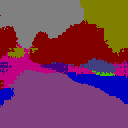

In [61]:
print(type(test(outputs[0])));
a = test(outputs[0]);
a = a.reshape([128, 128, 3])
print(a.shape)
from google.colab.patches import cv2_imshow
cv2_imshow(a)

error: ignored

In [0]:
print(total)

1048576


In [0]:
print(labels.shape)

torch.Size([4, 1, 512, 512])
